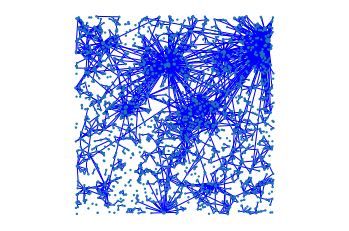

In [145]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from scipy.spatial.distance import pdist, squareform


def _generate_weights(tau=None,
                      expected_weight=None,
                      size=None):
    """Return numpy array of weights"""
    return np.random.random(size)**(-1/(tau-1))*(expected_weight)*(tau-2)/(tau-1)

class GIRG:
    """
    Geometric Inhomogeneous Random Graph. 
    Vertices are placed uniformly in a box/torus of length n^(1/d), where n is the number of vertices. 
    Vertices are equipped with an i.i.d. weight following a power law with specified expectation,
    i.e., of the form P(W>w) = cx^{-(\tau-1)}.
    Conditionally on the weights, two vertices x, y are connected with probability 
    p(x,y) = 1 - exp((W_x W_y / |x-y|^d)^alpha),
    where |x-y| denotes the two-norm in Euclidean space, or on the torus.
    
    Note that there are more general functions p(x,y) described in literature.
    
    Geometric inhomogeneous random graphs
    Karl Bringmann, Ralph Keusch, Johannes Lengler
    Theoretical Computer Science, Volume 760, 14 February 2019, p. 35-54
    https://doi.org/10.1016/j.tcs.2018.08.014
    
    Scale-free Percolation 
    Maria Deijfen, Remco van der Hofstad, Gerard Hooghiemstra
    Annales de l'I.H.P. Probabilités et statistiques, Volume 49 (2013) no. 3, p. 817-838 
    https://doi.org/10.1214/12-AIHP480
    """
    def __init__(self,
                 vertex_size,
                 alpha,
                 tau,
                 expected_weight,
                 on_torus=True,
                 dimension=2):
        self.vertex_size = vertex_size
        self.alpha = alpha
        self.tau = tau
        self.expected_weight = expected_weight
        self.dimension = dimension
        self.vertex_weights = _generate_weights(tau=tau,
                                                expected_weight=expected_weight,
                                                size=vertex_size)
        self.vertex_locations = self.generate_locations()
        self.graph = self.generate_graph(weights=self.vertex_weights,
                                         locations=self.vertex_locations,
                                         on_torus=on_torus)

    def _compute_isolated_star_attrs(self):
        isolated_star_dict = dict([(node, _isolated_star_number(self.graph, node))
                                   for node in self.graph.nodes()])
        nx.set_node_attributes(self.graph, isolated_star_dict, name="isolated_star")


    @property
    def torus_width(self):
        return self._torus_width(self.vertex_size, self.dimension)

    def _torus_width(self, vertex_size, dimension):
        return vertex_size**(1/dimension)

    def generate_locations(self,
                           size=None,
                           dimension=None):
        """Returns (size*dimension) numpy array with points on the d-dimensional torus
        of length size^(1/dimension)"""
        size = size or self.vertex_size
        dimension = dimension or self.dimension
        return (np.random.random(size=(size, dimension))
                * self._torus_width(size, dimension))

    def torus_distance(self,
                       point1,
                       point2,
                       torus_width=None):
        torus_width = torus_width or self.torus_width
        abs_diff = np.abs(point1 - point2)
        torus_diff = np.minimum(torus_width - abs_diff, abs_diff)
        return np.sum(torus_diff**2)**0.5

    def generate_adjacency_matrix(self,
                                  weights,
                                  locations,
                                  alpha=None,
                                  torus_width=None,
                                  on_torus=True):
        alpha = alpha or self.alpha
        torus_width = torus_width or self.torus_width
        vertex_size = len(weights)

        dimension = locations.shape[1]
        weights_multiplied = np.dot(weights.reshape(len(weights), 1),
                                    weights.reshape(1, len(weights)))
        distance_metric = self.torus_distance if on_torus else "euclidean"
        distances_pairwise = squareform(pdist(locations,
                                              distance_metric))
        np.fill_diagonal(distances_pairwise, val=1)
        edge_probabilities = 1 - np.exp(-(weights_multiplied / (distances_pairwise**dimension))**alpha)
        edge_probabilities_truncated = np.tril(edge_probabilities, k=-1)
        edge_rvs_uniform = np.random.random(size=(vertex_size, vertex_size))
        adjacency_matrix = (edge_rvs_uniform < edge_probabilities_truncated).astype(np.int)
        return adjacency_matrix + adjacency_matrix.T

    def generate_graph(self,
                       weights,
                       locations,
                       alpha=None,
                       torus_width=None,
                       on_torus=True):
        weight_dict = dict(zip(range(len(weights)), weights))
        position_dict = dict(zip(range(len(locations)), locations))
        graph = nx.from_numpy_matrix(self.generate_adjacency_matrix(weights=weights,
                                                                    locations=locations,
                                                                    alpha=alpha,
                                                                    torus_width=torus_width,
                                                                    on_torus=on_torus))
        nx.set_node_attributes(graph, weight_dict, name="weight")
        nx.set_node_attributes(graph, position_dict, name="position")
        return graph


    def draw(self):
        graph = self.graph
        if self.dimension != 2:
            raise NotImplementedError("I don't know how to draw a {}-dimensional graph".format(self.dimension))
        f = plt.figure()
        nx.draw_networkx_nodes(graph, pos=self.vertex_locations, node_size=2.3*self.vertex_weights**0.5)
        nx.draw_networkx_edges(graph, pos=self.vertex_locations, edge_color='b')
        plt.axis('equal')
        plt.axis('off')
        plt.rc('axes.spines', **{'bottom':True, 'left':True, 'right':False, 'top':False})
        plt.show()
        
if __name__ == '__main__':
    girg = GIRG(vertex_size=2000,                        
                alpha=2.5,
                tau=3,
                expected_weight=1,
                on_torus=False)
    girg.draw()

In [178]:
grid = []

for i in np.arange(1.1, 2.6, 0.4):
    for j in np.arange(2.2, 3.6, 0.4):
        
        cell = [i, j]
        grid.append(cell)

In [179]:
len(grid)

16

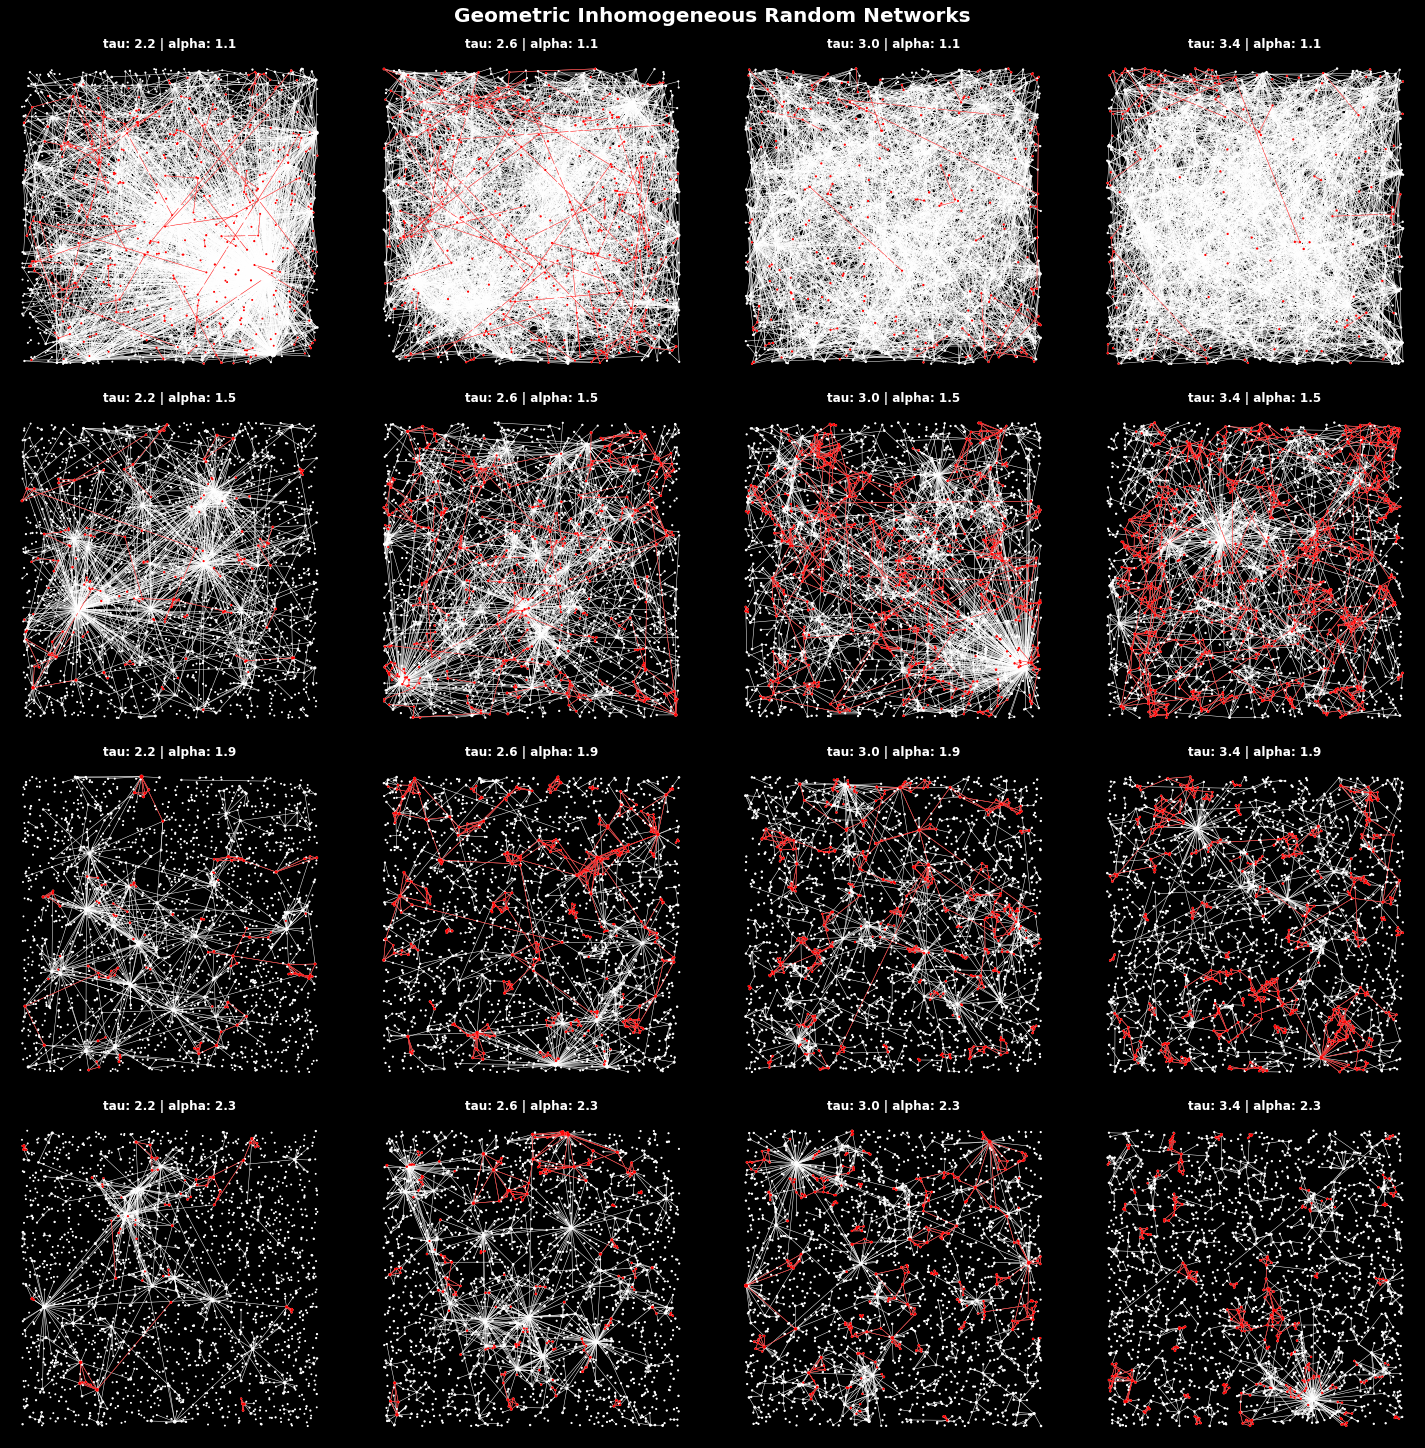

In [182]:
fig, axs = plt.subplots(4, 4, figsize=(20, 20), 
                        facecolor='k',
                        constrained_layout=True, 
                        subplot_kw=dict(aspect='equal'))

axs = axs.ravel()

for i in np.arange(0, 16):
    alpha = grid[i][0]
    tau   = grid[i][1]

    girg = GIRG(vertex_size=2000,                        
                alpha=alpha,
                tau=tau,
                expected_weight=0.75,
                on_torus=False)
        
    G_total = girg.graph
    G_shell = nx.algorithms.core.k_shell(G_total, k=3)
    
    weights = nx.get_node_attributes(G_total, 'weight')
    
    nx.draw_networkx_edges(G_total, ax=axs[i],
                           pos=nx.get_node_attributes(G_total, 'position'),
                           edge_color='w', width=0.5)
    nx.draw_networkx_nodes(G_total, ax=axs[i], 
                           pos=nx.get_node_attributes(G_total, 'position'), 
                           node_size=2.3*np.array(list(weights.values()))**0.5,
                           node_color='w')

    weights = nx.get_node_attributes(G_shell, 'weight')

    nx.draw_networkx_edges(G_shell, ax=axs[i],
                           pos=nx.get_node_attributes(G_shell, 'position'),
                           edge_color='r', width=0.5)
    nx.draw_networkx_nodes(G_shell, ax=axs[i],
                           pos=nx.get_node_attributes(G_shell, 'position'), 
                           node_size=2.3*np.array(list(weights.values()))**0.5,
                           node_color='r')

    axs[i].set_facecolor('k')
    axs[i].set_title(f"tau: {tau} | alpha: {alpha}", color='w', weight='bold')
        
fig.suptitle('Geometric Inhomogeneous Random Networks', color='w', size=20, weight='bold')
fig.savefig('girgs.png', facecolor=fig.get_facecolor(), dpi=120, bbox_inches='tight')